In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16,InceptionV3,ResNet50,EfficientNetB0,MobileNetV2

In [3]:
import os
import zipfile

local_zip = './Face_Mask.zip'
extract_to = './tmp'#./has to be there to tell to extract to it

# Ensure the target directory exists
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

# Extract the ZIP file
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [6]:
base_dir = './tmp/Face Mask Dataset'#see from the extracted and then do
train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Validation')
test_dir = os.path.join(base_dir,'Test')
# Directory with our training mask pictures
train_mask_dir = os.path.join(train_dir, 'WithMask')#withmask and all are folder names from the extracted ones

# Directory with our training without_masks pictures
train_without_mask_dir = os.path.join(train_dir, 'WithoutMask')

# Directory with our validation mask pictures
validation_mask_dir = os.path.join(validation_dir, 'WithMask')

# Directory with our validation without_masks pictures
validation_without_mask_dir = os.path.join(validation_dir, 'WithoutMask')

#Directory with our tests masks and without masks pictures
test_mask_dir = os.path.join(test_dir,'WithMask')
test_without_mask_dir = os.path.join(test_dir,'WithoutMask')

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator with the preprocessing function
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)#rescale does is to 255 to 0 to 1 normalize
test_datagen = ImageDataGenerator(rescale= 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # All images will be resized to 224x224
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),  # All images will be resized to 224x224
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # All images will be resized to 224x224
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary'
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [8]:
# training all the models now
models = [VGG16,InceptionV3,ResNet50,EfficientNetB0,MobileNetV2]

results = []
evaluation = []
def train_models(models):
  '''
  This function trains all the models in the models list and the plot for the model wrt to the loss and accuracy and tabulates the details in the form of a dataframe
  here only the basic training of the model is done with only training the fcnn part of the models and not the entire model
  '''
  for model in models:
    base_model = model(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    name = model.__name__
    print(f"Model being trained is {name} \n")
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
      layer.trainable = False

    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    history = model.fit(train_generator,epochs=10,validation_data=val_generator)

    #plotting the loss and accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    print("plots for model")
    fig,ax = plt.subplots(2,1,figsize=(10,10))
    ax[0].plot(acc,label='Training Accuracy')
    ax[0].plot(val_acc,label='Validation Accuracy')
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(loc='lower right')
    ax[0].set_title('Training and Validation Accuracy')
    ax[1].plot(loss,label='Training Loss')
    ax[1].plot(val_loss,label='Validation Loss')
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend(loc='upper right')
    ax[1].set_title('Training and Validation Loss')
    plt.show()

    #evaluating the model
    results.append({'model':name,'accuracy':history.history['accuracy'][-1],'val_accuracy':history.history['val_accuracy'][-1],'loss':history.history['loss'][-1],'val_loss':history.history['val_loss'][-1]})
    evaluation.append({'model':name,'evaluation':model.evaluate(test_generator)})


58889256/58889256 [==============================] - 2s 0us/step
Model being trained is VGG16 

Epoch 1/10
500/500 [==============================] - 62s 106ms/step - loss: 0.0965 - accuracy: 0.9631 - val_loss: 0.0520 - val_accuracy: 0.9800
Epoch 2/10
500/500 [==============================] - 56s 112ms/step - loss: 0.0481 - accuracy: 0.9797 - val_loss: 0.0397 - val_accuracy: 0.9837
Epoch 3/10
500/500 [==============================] - 56s 112ms/step - loss: 0.0365 - accuracy: 0.9871 - val_loss: 0.0536 - val_accuracy: 0.9812
Epoch 4/10
500/500 [==============================] - 57s 114ms/step - loss: 0.0344 - accuracy: 0.9868 - val_loss: 0.0371 - val_accuracy: 0.9850
Epoch 5/10
500/500 [==============================] - 56s 113ms/step - loss: 0.0254 - accuracy: 0.9919 - val_loss: 0.0321 - val_accuracy: 0.9850
Epoch 6/10
500/500 [==============================] - 58s 115ms/step - loss: 0.0255 - accuracy: 0.9915 - val_loss: 0.0248 - val_accuracy: 0.9912
Epoch 7/10
500/500 [==============

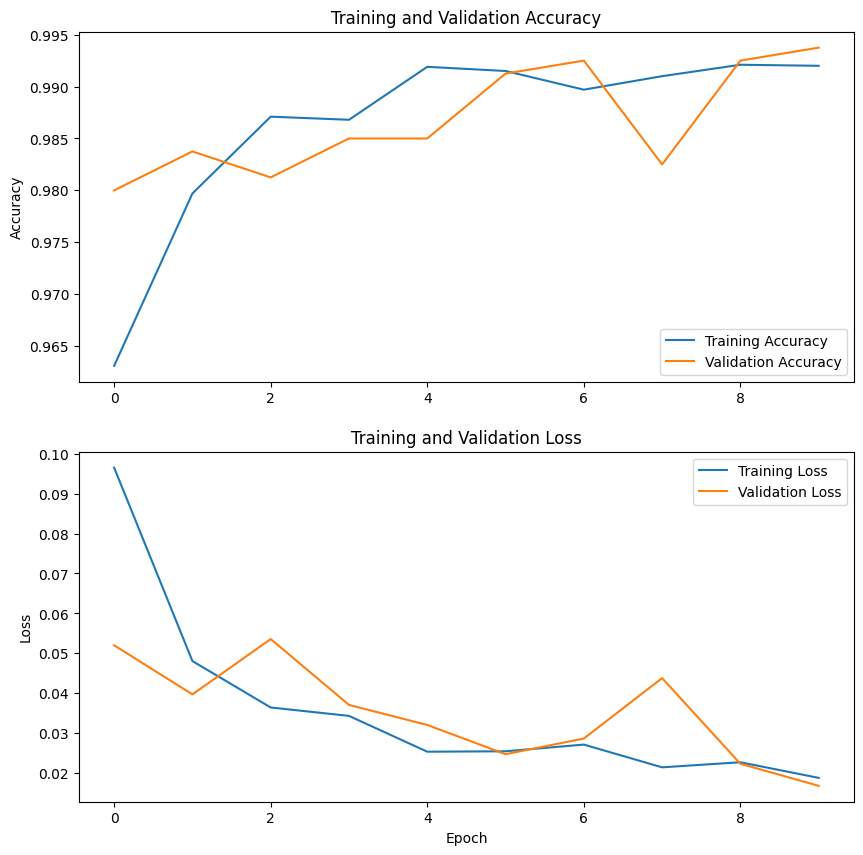

87910968/87910968 [==============================] - 3s 0us/step
Model being trained is InceptionV3 

Epoch 1/10
500/500 [==============================] - 39s 64ms/step - loss: 0.0356 - accuracy: 0.9905 - val_loss: 8.6502e-04 - val_accuracy: 1.0000
Epoch 2/10
500/500 [==============================] - 31s 62ms/step - loss: 0.0104 - accuracy: 0.9970 - val_loss: 0.0051 - val_accuracy: 0.9987
Epoch 3/10
500/500 [==============================] - 32s 65ms/step - loss: 0.0070 - accuracy: 0.9978 - val_loss: 2.2042e-04 - val_accuracy: 1.0000
Epoch 4/10
500/500 [==============================] - 32s 65ms/step - loss: 0.0048 - accuracy: 0.9986 - val_loss: 0.0058 - val_accuracy: 0.9975
Epoch 5/10
500/500 [==============================] - 32s 64ms/step - loss: 0.0134 - accuracy: 0.9964 - val_loss: 5.6103e-04 - val_accuracy: 1.0000
Epoch 6/10
500/500 [==============================] - 32s 65ms/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 0.0011 - val_accuracy: 0.9987
Epoch 7/10
500/500 [==

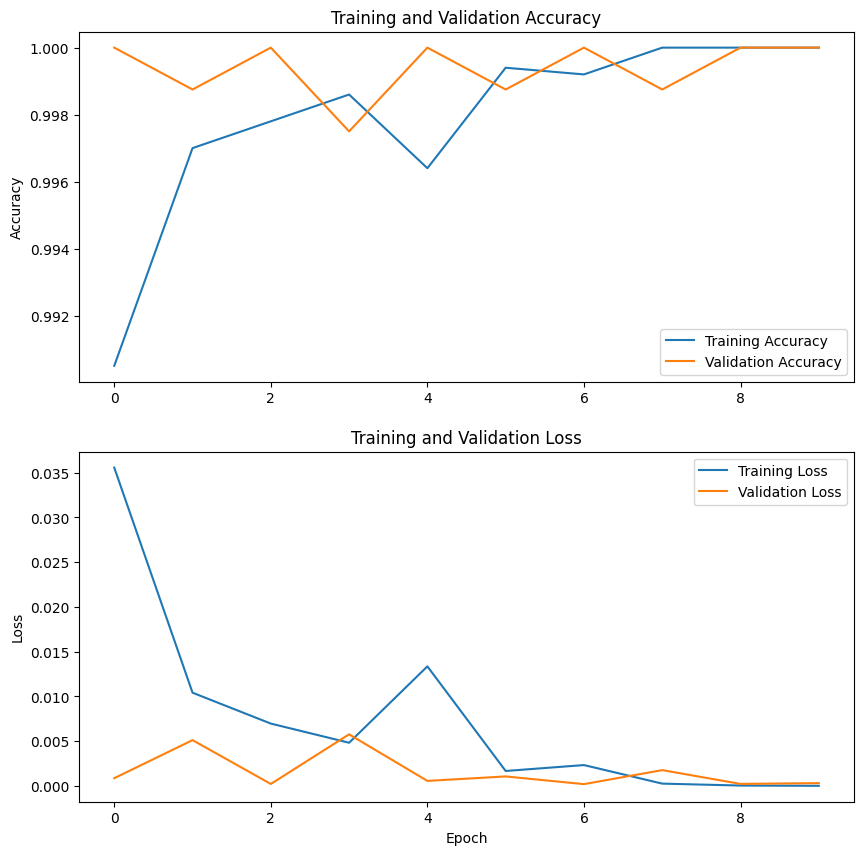

94765736/94765736 [==============================] - 3s 0us/step
Model being trained is ResNet50 

Epoch 1/10
500/500 [==============================] - 52s 92ms/step - loss: 0.5820 - accuracy: 0.6876 - val_loss: 0.5170 - val_accuracy: 0.7300
Epoch 2/10
500/500 [==============================] - 44s 88ms/step - loss: 0.4107 - accuracy: 0.8219 - val_loss: 0.3225 - val_accuracy: 0.8700
Epoch 3/10
500/500 [==============================] - 45s 89ms/step - loss: 0.3294 - accuracy: 0.8639 - val_loss: 0.4038 - val_accuracy: 0.8087
Epoch 4/10
500/500 [==============================] - 45s 89ms/step - loss: 0.3022 - accuracy: 0.8736 - val_loss: 0.3196 - val_accuracy: 0.8712
Epoch 5/10
500/500 [==============================] - 44s 88ms/step - loss: 0.2894 - accuracy: 0.8815 - val_loss: 0.2638 - val_accuracy: 0.9137
Epoch 6/10
500/500 [==============================] - 44s 89ms/step - loss: 0.2646 - accuracy: 0.8962 - val_loss: 0.2652 - val_accuracy: 0.9025
Epoch 7/10
500/500 [=================

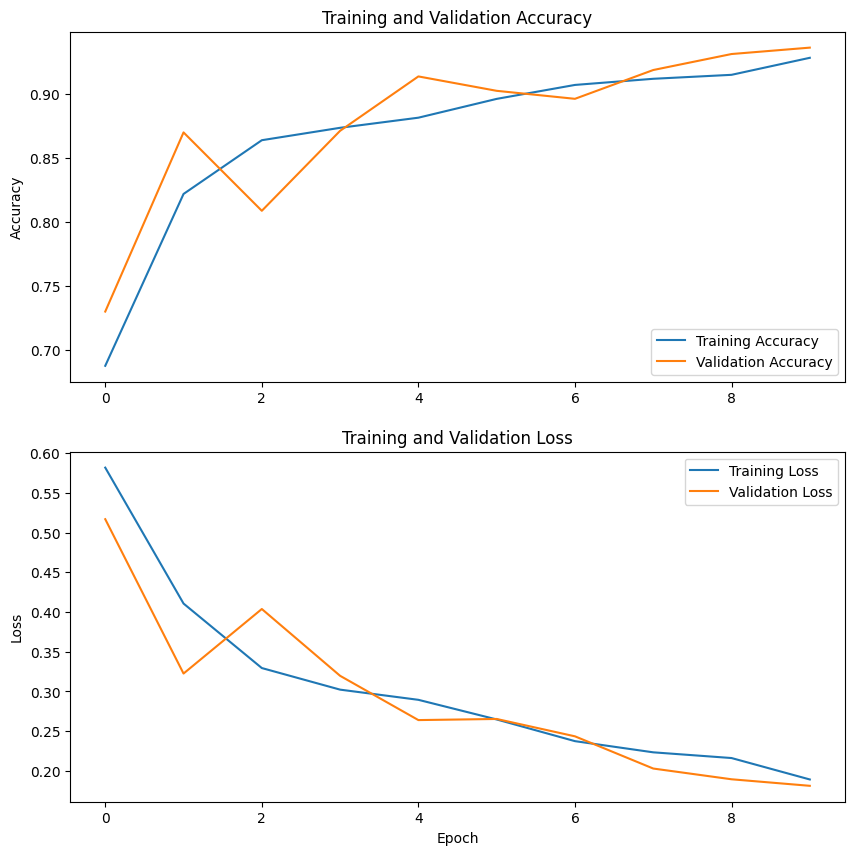

16705208/16705208 [==============================] - 1s 0us/step
Model being trained is EfficientNetB0 

Epoch 1/10
500/500 [==============================] - 46s 72ms/step - loss: 0.7051 - accuracy: 0.5004 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 2/10
500/500 [==============================] - 30s 61ms/step - loss: 0.6942 - accuracy: 0.4974 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 3/10
500/500 [==============================] - 31s 62ms/step - loss: 0.6934 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/10
500/500 [==============================] - 30s 61ms/step - loss: 0.6936 - accuracy: 0.5058 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/10
500/500 [==============================] - 33s 65ms/step - loss: 0.6932 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
500/500 [==============================] - 31s 61ms/step - loss: 0.6932 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
500/500 [===========

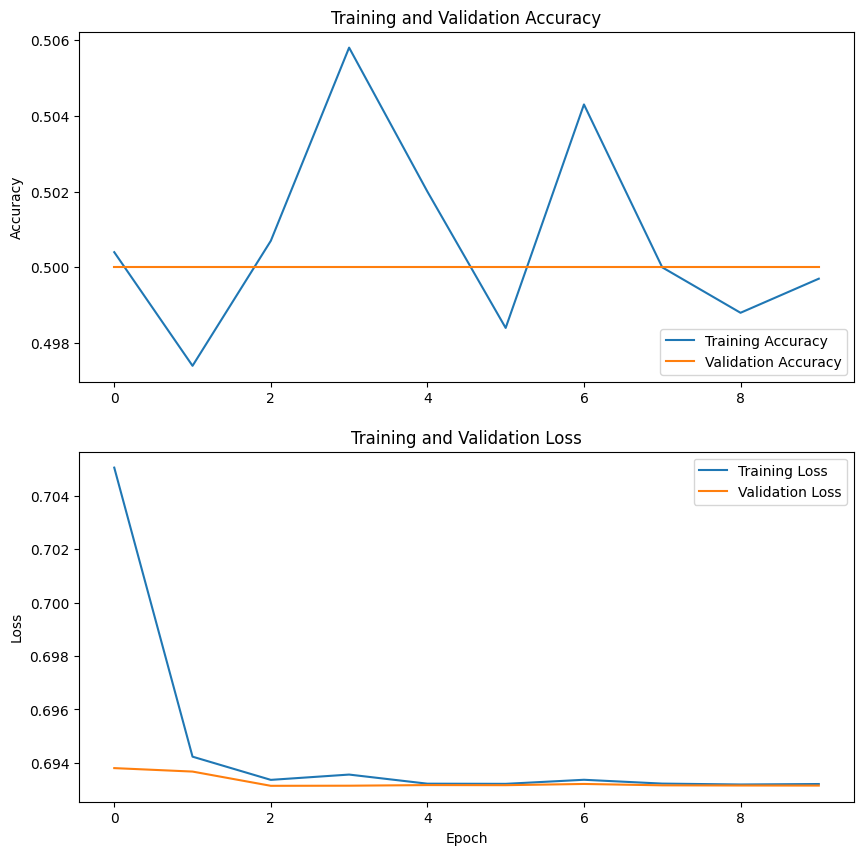

9406464/9406464 [==============================] - 1s 0us/step
Model being trained is MobileNetV2 

Epoch 1/10
500/500 [==============================] - 34s 61ms/step - loss: 0.0508 - accuracy: 0.9838 - val_loss: 0.0195 - val_accuracy: 0.9937
Epoch 2/10
500/500 [==============================] - 29s 57ms/step - loss: 0.0162 - accuracy: 0.9947 - val_loss: 0.0144 - val_accuracy: 0.9925
Epoch 3/10
500/500 [==============================] - 28s 56ms/step - loss: 0.0093 - accuracy: 0.9963 - val_loss: 0.0214 - val_accuracy: 0.9937
Epoch 4/10
500/500 [==============================] - 29s 57ms/step - loss: 0.0105 - accuracy: 0.9966 - val_loss: 0.0377 - val_accuracy: 0.9875
Epoch 5/10
500/500 [==============================] - 29s 57ms/step - loss: 0.0114 - accuracy: 0.9958 - val_loss: 0.0131 - val_accuracy: 0.9962
Epoch 6/10
500/500 [==============================] - 28s 56ms/step - loss: 0.0056 - accuracy: 0.9979 - val_loss: 0.0178 - val_accuracy: 0.9962
Epoch 7/10
500/500 [================

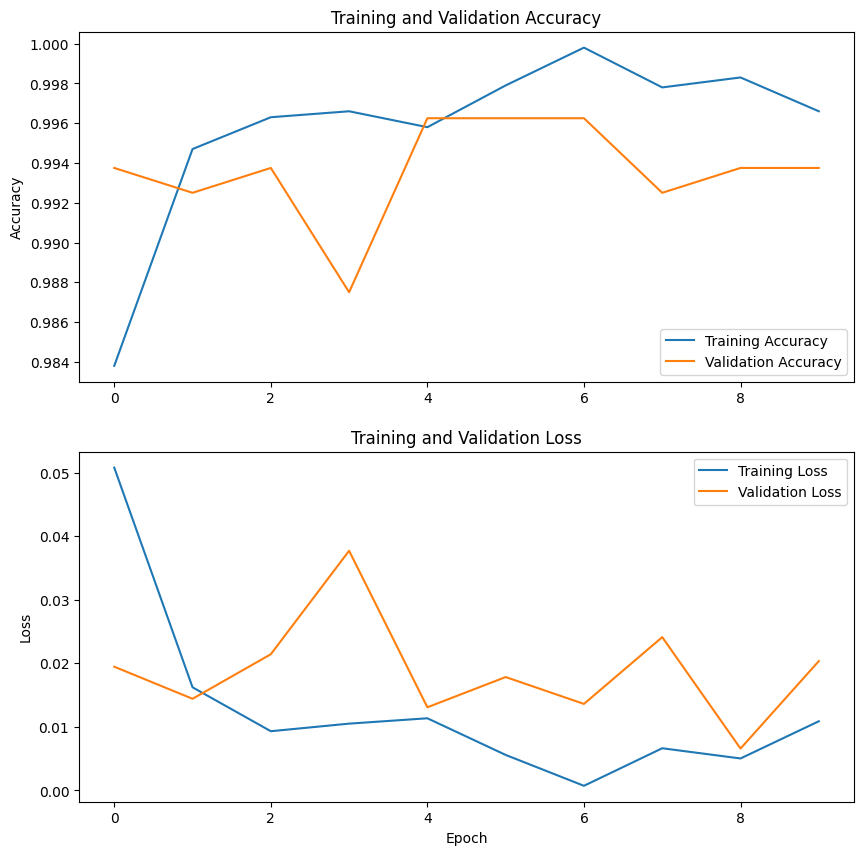

50/50 [==============================] - 3s 58ms/step - loss: 0.0316 - accuracy: 0.9950


In [9]:
train_models(models)

In [10]:
#results
results_df = pd.DataFrame(results)
results_df

,model,accuracy,val_accuracy,loss,val_loss
0,VGG16,0.9920,0.99375,0.018835,0.016849
1,InceptionV3,1.0000,1.00000,0.000012,0.000313
2,ResNet50,0.9283,0.93625,0.188990,0.180990
3,EfficientNetB0,0.4997,0.50000,0.693206,0.693147
4,MobileNetV2,0.9966,0.99375,0.010888,0.020349


In [11]:
# the test data evalutaion
evaluation_df = pd.DataFrame(evaluation)
evaluation_df

,model,evaluation
0,VGG16,"[0.02875494956970215, 0.9899193644523621]"
1,InceptionV3,"[0.0030851976480334997, 0.9989919066429138]"
2,ResNet50,"[0.15366050601005554, 0.9516128897666931]"
3,EfficientNetB0,"[0.6931653022766113, 0.4868951737880707]"
4,MobileNetV2,"[0.03155454620718956, 0.9949596524238586]"
